<a href="https://colab.research.google.com/github/R-HUA/COMP90086-project/blob/main/%E2%80%9CCOMP90086_ipynb%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Project

## Import Libraries

In [124]:
import os
import math
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
import threading
global THREAD_NUM 

## Load sample images

In [125]:
# read the photos and disparity maps in the folder and save them in
# a dictionary indexed by the file name

cwd = os.getcwd()
data_set = cwd +"/Dataset"

file_names = os.listdir(data_set)

imgs = {}
ground_truth = {}
for i in range(len(file_names)):
    if file_names[i].endswith('.jpg'):
        fname = file_names[i][:43]
        ftype = file_names[i][-4:]
        imgs[fname] = [cv2.imread(data_set + '/' + fname  + '-left.jpg',cv2.IMREAD_GRAYSCALE), cv2.imread(data_set + '/' + fname  + '-right.jpg',cv2.IMREAD_GRAYSCALE)]
        ground_truth[fname] = cv2.imread(data_set + '/' + fname  + '-disparity.png', -1)  # 16bit png

## Show sample image

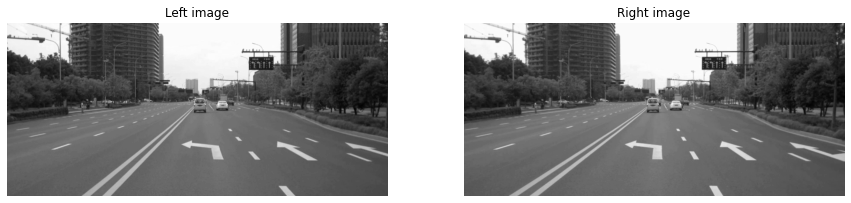

In [134]:
# Show images
img_name = "2018-07-09-16-11-56_2018-07-09-16-11-56-702"
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(imgs[img_name][0], cmap='gray')  
plt.title("Left image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(imgs[img_name][1], cmap='gray')  
plt.title("Right image")
plt.axis('off')

plt.show() 

# Question 1
To calculate a disparity map for the left image using classical (non deep learning) methods

## Sum of Squared Differences (SSD)

In [127]:
global SEARCH_BLOCK_SIZE
SEARCH_BLOCK_SIZE = 32
THREAD_NUM = 16

def ssd_(st,end,imgL,imgR,window_size,disparity):
    width, height = imgL.shape[:2]

    for i in range(st,end):
      for j in range(window_size//2, height-window_size//2):
          min_ssd = float('inf')
          for k in range(SEARCH_BLOCK_SIZE):
            if j-k < window_size//2:
              break
            ssd = np.sum((imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1] - imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k])**2)
  
            if ssd < min_ssd:
              min_ssd = ssd
              disparity[i,j] = k 


def ssd(imgL,imgR,window_size):
  width, height = imgL.shape[:2] 
  d = np.zeros((width, height), np.uint16)
  st = window_size//2
  end = width-window_size//2
  chunk = math.ceil((end - st) / THREAD_NUM)
  thread_list = []
  for treadno in range(THREAD_NUM):
    i_end = min((st + chunk * (treadno+1),end))
    t = threading.Thread(target=ssd_,args=((st + chunk * treadno),i_end,imgL,imgR,window_size,d))
    t.start()
    thread_list.append(t)
  for i in range(len(thread_list)):
    thread_list[i].join()
  return d

## Disparity map calculation

In [22]:
disparity = {}
for fname in imgs.keys():
  start_time = time.time()

  width, height = imgs[fname][0].shape[:2]
  disparity[fname] = ssd(imgs[fname][0],imgs[fname][1],15) 

  end_time = time.time()
  run_time = end_time - start_time
print(run_time)

# Question 2

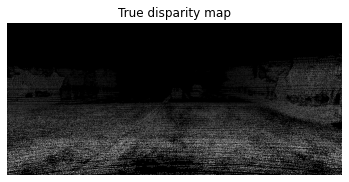

In [128]:
# Show images
plt.imshow(ground_truth[img_name], cmap='gray')  
plt.title("True disparity map")
plt.axis('off')

plt.show() 

## errors

In [131]:
def errors(img_truth,estimated_disparity):
  avliable_pixels = np.where(img_truth != 0)
  errors = np.abs(img_truth[avliable_pixels]-estimated_disparity[avliable_pixels])
  # root mean square error
  rms = np.sqrt(np.mean(errors **2))
  # percentage of errors by pixels
  errors4 = np.where(errors < 4)[0].shape[0]/avliable_pixels[0].shape[0] 
  errors2 = np.where(errors < 2)[0].shape[0]/avliable_pixels[0].shape[0] 
  errors1 = np.where(errors < 1)[0].shape[0]/avliable_pixels[0].shape[0] 
  errors0_5 = np.where(errors< 0.5)[0].shape[0]/avliable_pixels[0].shape[0] 
  errors0_25 = np.where(errors < 0.25)[0].shape[0]/avliable_pixels[0].shape[0] 

  return rms, (errors4,errors2,errors2,errors0_5,errors0_25)


In [137]:
print(img_name)
errors(ground_truth[img_name]/256,disparity[img_name]/256)

2018-07-09-16-11-56_2018-07-09-16-11-56-702


(20.445513695225685,
 (0.5446800304030676,
  0.4638736684477419,
  0.4638736684477419,
  0.2217722265709197,
  0.12458451031775743))

In [136]:
x = cv2.GaussianBlur(disparity[img_name], (3,3), 1.5);
errors(ground_truth[img_name]/256,x/256)

(20.297210412433337,
 (0.5414355239424157,
  0.4641913124368966,
  0.4641913124368966,
  0.23097255782822268,
  0.13195838863742074))

# Test the window size

In [ ]:
e = [[] for _ in range(3,27,4)]
run_time = [-1 for _ in range(3,27,4)]
for size in range(3,27,2):
  for img_name in imgs.keys():
    start_time = time.time()

    d = ssd(imgs[img_name][0],imgs[img_name][1],i)
    e[(i-3)//4].append(errors(ground_truth[img_name]/256,d))

    end_time = time.time()
    run_time[(i-3)//4] += (end_time - start_time)
  

e = np.array(e)
e = np.sum(e,axis = 0) / len(imgs.keys())
run_time = np.array(run_time) / len(imgs.keys())
  
  

for i in range(3,27,2):
  print("window size:",i)
  print("run_time:",run_time[(i-3)//4])
  print("rms:",e[(i-3)//4][0])
  print("error <4 <2 <1 <0.5 <0.25", e[(i-3)//4][1:])



# Sub­pixel estimation

In [66]:
SEARCH_BLOCK_SIZE = 32
THREAD_NUM = 1

def ssd_(st,end,imgL,imgR,window_size,disparity):
    width, height = imgL.shape[:2]

    for i in tqdm(range(st,end)):
      for j in range(window_size//2, height-window_size//2):
          ssd_k = []
          for k in range(SEARCH_BLOCK_SIZE):
            if j-k < window_size//2:
              break
            ssd = np.sum((imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1] - imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k])**2)
  
            ssd_k.append([ssd,k])
            ssd_k.sort()
            ssd_k = ssd_k[:3]
          if len(ssd_k) >= 3:
            ssd_k.sort()
            k_min = ssd_k[0][1]
            ssd_min = ssd_k[0][0]
            lb = None
            ls = None
            for t in ssd_k:
              if lb is None or ls is None:
                if t[1] > k_min and lb is None:
                  lb = t[0]
                elif t[1] < k_min and ls is None:
                  ls = t[0]
            if lb is None or ls is None:
              disparity[i,j] = ssd_k[0][1] * 256
            else:
              disparity[i,j] = (k_min - 0.5 * (lb - ls)/(ls - 2 * ssd_min + lb)) * 256
          else:
            disparity[i,j] = ssd_k[0][1] * 256



          #print(ssd_k)
          #ks = [ssd_k[0][1],ssd_k[1][1],ssd_k[2][1]]
          #ssds = [ssd_k[0][0],ssd_k[1][0],ssd_k[2][0]]
          #if ssd_k[2][0] < float('inf'):
          #  disparity[i,j] = (ssd_k[0][1] - 0.5 * (ssd_k[2][0] - ssd_k[1][0])/(ssd_k[1][0] - 2 * ssd_k[0][0] + ssd_k[2][0])) * 256
          #  if disparity[i,j] > max(ks) or disparity[i,j] < min(ks):
          #    #print(ssd_k)
          #    disparity[i,j] = ssd_k[0][1] * 256
          #else:
          #  disparity[i,j] = ssd_k[0][1] * 256
          # if y[2] < float('inf') and y[1] < float('inf') and y[0] < float('inf'):
          #   coef = np.polyfit(x, y, 2)
          #   min_k = - (coef[1]/ (2*coef[0]))  # -b/2a
          #   if min_k < min(x) or min_k > max(x):
          #     print(ssd_k)
          #     disparity[i,j] = (min(x) + max(x)) /2
          #   else:
          #     disparity[i,j] = min_k * 256   # vertex 
          # else:
          #   disparity[i,j] = ssd_k[0][1] * 256


def ssd(imgL,imgR,window_size):
  width, height = imgL.shape[:2] 
  d = np.zeros((width, height), np.uint16)
  st = window_size//2
  end = width-window_size//2
  chunk = math.ceil((end - st) / THREAD_NUM)
  thread_list = []
  for treadno in range(THREAD_NUM):
    i_end = min((st + chunk * (treadno+1),end))
    #t = threading.Thread(target=ssd_,args=((st + chunk * treadno),i_end,imgL,imgR,window_size,d))
    ssd_((st + chunk * treadno),i_end,imgL,imgR,window_size,d)
    #t.start()
    #thread_list.append(t)
  for i in range(len(thread_list)):
    thread_list[i].join()
  return d


In [67]:
start_time = time.time()
width, height = imgs[fname][0].shape[:2]
d = ssd(imgs[fname][0],imgs[fname][1],15) 
end_time = time.time()
run_time = end_time - start_time

100%|██████████| 386/386 [01:55<00:00,  3.34it/s]


2018-07-09-16-11-56_2018-07-09-16-11-56-702


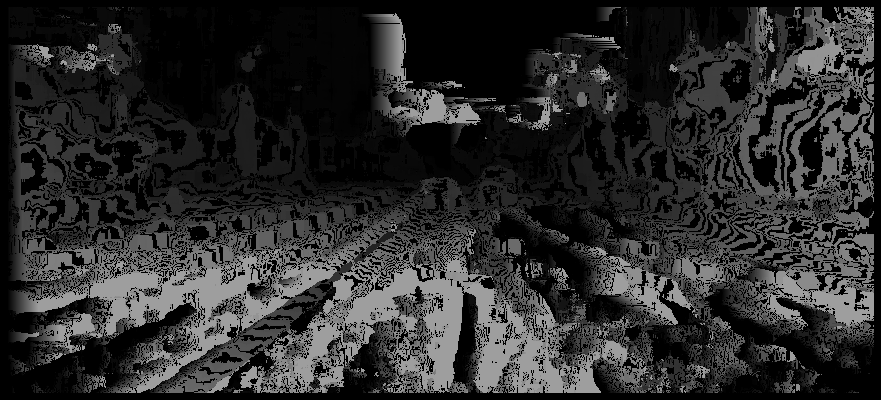

(23.77942265876921,
 (0.34200047646598375,
  0.28350860474877765,
  0.28350860474877765,
  0.1372675810275783,
  0.0770740450827576))

In [68]:
print(fname)
from google.colab.patches import cv2_imshow
d = cv2.GaussianBlur(d, (5,5), 1.5);
cv2_imshow(d/50)
errors(ground_truth[fname]/256,d/256)

# DP

In [69]:
from PIL import Image
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal
from scipy.signal import convolve2d as conv2d
import time



In [70]:
def create_img(filename,):
        im = Image.open(filename).convert('L') #.convert('L') converts the image to grayscale
        # im.save('AAA.jpg')
        return np.array(im).astype(np.int32)
def convCPU(matrix, kernel):
    convRes = conv2d(matrix,kernel, mode='same')
    return convRes

In [104]:
mask = np.ones((6,6),dtype=np.int16)
imageL = create_img("/content/Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg")
#  imageL = convCPU(imageL,mask)
imageR = create_img("/content/Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg")
# imageR = convCPU(imageR,mask)
height = imageL.shape[0]
width = imageR.shape[1]

start = time.time()
# print imageL.shape
depthMap = []
# print list(imageL[0])
# print list(imageR[0])
for line in tqdm(range(height)):

    disparityMap = np.zeros((width,40),dtype=np.int16)

    for i in range(width):
        for j in range(40):
            if i+j < 20:
                disparityMap[i][j] = 0
            elif  i+j > width+20:
                disparityMap[i][j] = 10000
            elif i > 0 and j > 0 and j < 39 and i+j < width+20 and i+j > 20:
                disparityMap[i][j] = min(disparityMap[i-1][j],disparityMap[i-1][j+1],disparityMap[i][j-1]) + np.abs(imageL[line][i]-imageR[line][i+j-20])
            elif i > 0 and j == 39 and i+j < width+20 and i+j > 20:
                disparityMap[i][j] = min(disparityMap[i-1][j],disparityMap[i][j-1]) + np.abs(imageL[line][i]-imageR[line][i+j-20])
            elif i > 0 and j == 0 and i+j < width+20 and i+j > 20:
                disparityMap[i][j] = min(disparityMap[i-1][j],disparityMap[i-1][j+1]) + np.abs(imageL[line][i]-imageR[line][i+j-20])
            elif i == 0 and i+j < width+20 and i+j > 20:
                disparityMap[i][j] = disparityMap[i][j-1] + np.abs(imageL[line][i]-imageR[line][i+j-20])
    # print list(disparityMap)

    startX = 20
    startY = width-1

    dispRes = np.ones((width,40))

    while startY > 0:
        # print startY
        if startX < 39 and startX > 0:
            if disparityMap[startY-1][startX] <= min(disparityMap[startY-1][startX+1], disparityMap[startY][startX-1]):
                dispRes[startY][startX] = 0
                startY -= 1
            elif disparityMap[startY-1][startX+1] <= min(disparityMap[startY-1][startX], disparityMap[startY][startX-1]):
                startX += 1
                startY -= 1
            elif disparityMap[startY][startX-1] <= min(disparityMap[startY-1][startX+1], disparityMap[startY-1][startX]):
                startX -= 1
        elif startX == 0:
            if disparityMap[startY-1][startX] <= (disparityMap[startY-1][startX+1]):
                dispRes[startY][startX] = 0
                startY -= 1
            elif disparityMap[startY-1][startX+1] <= (disparityMap[startY-1][startX]):
                startX += 1
                startY -= 1
        elif startX == 39:
            if disparityMap[startY-1][startX] <= disparityMap[startY][startX-1]:
                dispRes[startY][startX] = 0
                startY -= 1
            elif disparityMap[startY][startX-1] <= disparityMap[startY-1][startX]:
                startX -= 1
    #print( list(dispRes)

    depthMap1 = []

    for i in range(width):
        try:
            col = list(dispRes[i]).index(0)
            depthMap1.append(abs(col-20))
        except:
            depthMap1.append(0)

    depthMap.append(depthMap1)
print("execution time", time.time()-start)
depthMap = np.array(depthMap).astype(np.int16)
# print list(depthMap)
#depthMap = convCPU(depthMap,mask)
#depthMap = depthMap*256//np.max(depthMap)

#new_im = Image.fromarray(depthMap)
#new_im.convert('RGB').save('depth.jpg')

100%|██████████| 400/400 [01:42<00:00,  3.90it/s]

execution time 102.60393762588501


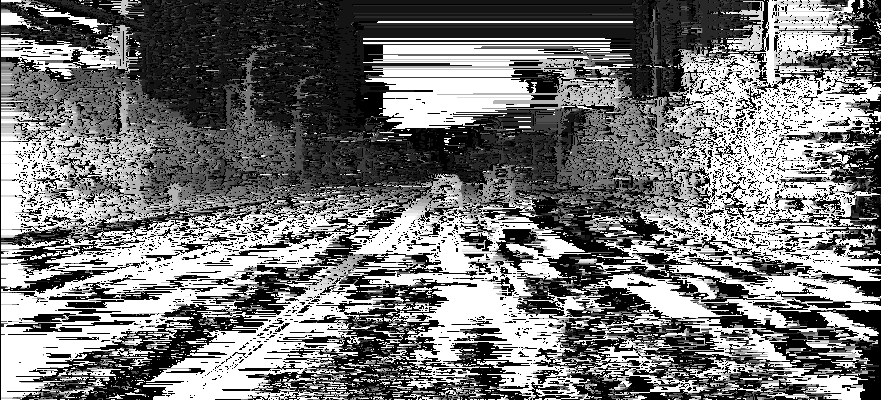

(25.036323010906912,
 (0.2850060692690785,
  0.22137517158447628,
  0.22137517158447628,
  0.08873611725600972,
  0.04821381978241387))

In [114]:
from google.colab.patches import cv2_imshow
cv2_imshow(depthMap * 20)
errors(ground_truth[fname]/256,depthMap)

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import copy

left_I = cv2.imread('/content/Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg',cv2.IMREAD_GRAYSCALE)
right_I = cv2.imread('/content/Dataset/2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg',cv2.IMREAD_GRAYSCALE)

In [ ]:
I_disp = np.zeros(left_I.shape)
disp_range = 55
h_block_size = 9
blocksize = h_block_size * 2 + 1
row = left_I.shape[1-1]
col = left_I.shape[2-1]
min_diff = float('inf')
disp_cost = min_diff * np.ones((col,2 * disp_range+1))
penalty = 0.4

In [ ]:
for m in tqdm(range(0,row)):
    disp_cost = min_diff * np.ones(disp_cost.shape)
    row_min = max(0,m - h_block_size)
    row_max = min(row - 1,m + h_block_size)
    for n in range(0,col):
        col_min = max(0,n - h_block_size -1)
        col_max = min(col - 1,n + h_block_size -1)

        pix_min = max(- disp_range -1,1 - col_min -1)
        pix_max = min(disp_range -1,col - col_max -1)
        for i in range(pix_min,pix_max+1):
          LL = left_I[row_min:row_max+1,col_min + i: col_max + i+1]
          RR = right_I[row_min:row_max+1,col_min:col_max+1]
          if LL.shape == RR.shape:

            aaa = np.sum((LL - RR )**2)
            disp_cost[n,i + disp_range + 1] = aaa

    Index = np.zeros(disp_cost.shape)
    c_p = disp_cost[-1,:]
    for j in range(col-1,0,-1):
        diff = min_diff * (col - j + 1)

        arr = np.array([np.concatenate(([diff,diff],c_p[0:-4] + (3 * penalty))),
                 np.concatenate(([diff],c_p[0:-3] + (2 * penalty))),
                 c_p[0:-2]  + penalty,
                 c_p[1:-1] ,
                 c_p[2:] + penalty,
                 np.concatenate((c_p[3:] + (4 * penalty),[diff])),
                 np.concatenate((c_p[4:] + (5 * penalty),[diff,diff]))])
        z = np.amin(arr,axis = 0)
        inx = np.argmin( arr,axis = 0)
        c_p = np.concatenate(([diff],disp_cost[j,1:-1] + z,[diff]))
        Index[j,1:-1] = (np.arange(1,disp_cost.shape[1]-1) + (inx - 4))
    inx = np.argmin(c_p)
    I_disp[m,0] = inx
    for k in range(1,col):
      I_disp[m,k] = Index[k -1 ,max(0,min(Index.shape[1] -1,round(I_disp[m,k-1])))]

I_disp = I_disp - disp_range - 1
